# Projet Julia : problème d'échange de reins avec un Branch and Price

Roméo Legoupil, Matthieu Roux, Marie-Charlotte Fougère--Ballé, Marc Le Moing

## Introduction

La maladie rénale chronique est une des maladies graces qui menacent la vie de nombreuses personnes. Cette maladie est la onzième cause de décès dans le monde, environ 2,17% des décès annuels. Il existe deux traitements pour cette maladie : 
- la dialyse : elle est plus facilement accessible mais elle nécessite de nombreuses visites à l'hôpital et des dépenses considérables. Cela réduit donc la qualité de vie du patient.
- la transplantation d'organe (de rein) : lorsqu'elle est réalisée avec succès, cela permet au patient de poursuivre sa vie sans aucun problème de santé.
Le traitement privilégié est donc la transplantation d'organe.

Normalement, ces transplantations sont réalisées à partir de donneurs décédés. Or, le nombre de patients  en attente d'un organe dépasse le nombre d'organes disponibles. Ainsi, il est maintenant possible de recevoir le rein d'un donneur vivant. Une transplantation rénale avec donneur vivant est réalisée entre un patient et un donner disposé à lui donner un de ses reins. Des tests de compatibilité doivent aussi être effectués entre le patient et le donneur avant que l'opération ait lieue. Lorsque le patient et le donneur sont incompatibles, les programmes d'échange de reins sont une solution alternative.

Un programme d'échange de reins est un système qui contient un ensemble de paires patient-donneur incompatibles. On peut apparier un patient avec le donneur vivant d'un autre patient avec lequel il est compatible. Les cycles d'échanges peuvent donc être construits de telle sorte que le donneur de chaque paire du cycle donne son rein au patient de la paire suivante et que le donneur de la dernière paire donne son rein au patient de la première paire. Les cycles longs ne sont pas souhaitables en raison de contraintes éthiques et logistiques. Ainsi, une longueur maximale de cycle est très souvent imposée.

Dans ce projet, nous allons donc trouver la meilleure façon de créer des cycles d'échange de reins de manière à maximiser le bien-être commun tout en respectant une longueur maximale de cycles d'échange. Ce problème est appelé problème d'échange de reins.

## Notations

Le problème d'échange de reins, que l'on note KEP par la suite, peut être représenté par un simple graphe orienté G=(V,A). V représente les paires patient-donneur $(P_i,D_i)$ et A représente la compatibilité entre les paires. Ainsi, $(i,j) \in A$ si le donneur $D_i$ et compatible avec le patient $P_j$.

Un score de priorité ou d'utilité est attribué à chaque arc $(i,j)$. L'arc prendre la valeur 1 si toutes les greffes sont considérées comme égales. L'objectif est de maximiser le nombre de greffes réalisées. L'utilité de l'arc $(i,j)$ est notée par $w_{ij}$.

Soit $L$ la longueur maximale d'un cycle. On note $C_L$ l'ensemble des cycles de G tel que $|c| \le L$ pour $c \in C_L$. $C_L$ représente donc l'ensemble des cycles de G de longueur inférieure à $L$. On définit $C_L(i)$ l'ensemble des cycles qui contiennent le noeuds $i \in V$ et $w_c=\sum_{(i,j) \in c} w_{ij}$ pour $c \in C_L$.

On a la variable $z_c$ pour $c \in C_L(i)$ qui vaut :
- 1 si le cycle $c$ est choisi,
- 0 sinon.

Voici une formulation du problème, appelée la formulation par cycles :

max $\sum_{c \in C_L} w_c z_c$

tel que :    
 - $\sum_{c \in C_L(i)} z_c \le 1, \forall i \in V$, (chaque paire est dans au plus un cycle)
 - $z \in \{0,1\}^{|C_L|}$.
    

Comme cette formulation a un grand nombre de variables, le but du projet est d'obtenir une solution en utilisant l'algorithme du Branch and Price vu en cours. Pour cela, nous allons trouver le problème maitre, les sous problèmes et comment générer une colonne afin de générer l'algorithme de la génération de colonnes. De plus, pour implémenter le Branch and Price, nous allons devoir trouver et éliminer les solutions fractionnaires ainsi que trouver la façon de brancher.

## Importations et lecture des données

### Importation des packages nécessaires

On importe tous les packages nécessaires pour notre code.

In [1]:
using JuMP 
using Gurobi
using DelimitedFiles
using NBInclude
const GUROBI_ENV = Gurobi.Env()
const ϵ = 0.00001

Set parameter Username
Academic license - for non-commercial use only - expires 2023-02-17


1.0e-5

### Importation des fichiers code nécessaires

On importe maintenant les fichiers code nécessaires pour notre projet. En effet, pour mieux organiser notre projet, nous avons séparé notre code en différents fichiers. Chaque fichier permet de coder une partie de notre projet. 

In [14]:
@nbinclude("dataparser.ipynb")
@nbinclude("mip.ipynb")
@nbinclude("master.ipynb")
@nbinclude("typedef.ipynb")
@nbinclude("subproblem.ipynb")
@nbinclude("branch_and_price.ipynb")
@nbinclude("node.ipynb")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`


### Lecture des données

In [5]:
data_folder = string(@__DIR__,"/data")
instance_name = "MD-00001-00000010"
filename = joinpath(data_folder, join([instance_name]))
new_inst = Instance(filename, 3, 0)

Instance({16, 47} directed simple Int64 graph, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0 0.0 … 0.0 1.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], Int64[], 16, 0, 3, 0, true)

## Résolution du MIP

Dans cette partie, nous allons résoudre le problème d'échange de reins sur les données que l'on stocke dans la variable $instance\_name$. Pour cela, on appelle la fonction que l'on a créée dans un fichier code séparé.

In [6]:
result = @timed solve_MIP()

Set parameter Username
Academic license - for non-commercial use only - expires 2023-02-17


(value = (4.0, [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]), time = 11.281915461, bytes = 1290394118, gctime = 0.521524302, gcstats = Base.GC_Diff(1290394118, 0, 0, 21970776, 5648, 0, 521524302, 18, 0))

In [7]:
println("La solution optimale est : ",result[1][1])
println("La matrice des solutions est : ",result[1][2])

La solution optimale est : 4.0
La matrice des solutions est : [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 -0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 1.0 0.0 0.0 -0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.0 0.0 0.0 -0.0; 0.0 0.0 0.0 0.0 0.0 0.0

In [8]:
solution=result[1][2]
P=size(new_inst.pairs)[1]

println("Paires patient-donneur : ")
for i in 1:P
    print(i," : ")
    for j in 1:P
        if solution[i,j]>0
            print("(",i,",",j,") avec poids ", solution[i,j])
        end
    end
    println("")
end

Paires patient-donneur : 
1 : 
2 : 
3 : (3,14) avec poids 1.0
4 : (4,6) avec poids 1.0
5 : 
6 : (6,4) avec poids 1.0
7 : 
8 : 
9 : 
10 : 
11 : 
12 : 
13 : 
14 : (14,3) avec poids 1.0
15 : 
16 : 


In [16]:
# Nombre de paires de donneurs/patients, nombre de noeuds du graphe :
P=size(new_inst.pairs)[1]
# Longueur maximale d'un cycle
L=new_inst.max_cycle_length

3

## Résolution du problème via la génération de colonne

Tout d'abord, on pose le sous-ensemble $C_L' \subset C_L$ __Mettre le symbole inclus ou égale__

Le problème maître restreint devient :

\begin{align}
&max \sum_{c \in C_L'} w_c z_c \\
&tel que :\\
& \sum_{c \in C_L'(i)} z_c \le 1, \forall i \in V \\
& z \in \{0,1\}^{|C_L'|} \\
\end{align}

On note $z_c=1$ si le cycle $c$ est choisi.

On réécrit la relaxation du problème en la mettant sous forme de minimisation :

\begin{align}
&- min \sum_{c \in C_L'} w_c z_c \\
&tel que :\\
& \sum_{c \in C_L'(i)} z_c \le 1, \forall i \in V \\
& z \in [0,1]^{|C_L'|} \\
\end{align}
$


Soit $\overline{x}^c$, le pattern du cycle c, $w_{ij}$ le poids de l'arc ij.

On peut réécrire le problème maître comme suit : (__à revoir__)
\begin{align}
&- min \sum_{c \in C_L'}  z_c \\
&tel que :\\
& \sum_{c \in C_L'(i)} z_c \le 1, \forall i \in V \\
& z \in [0,1]^{|C_L'|} \\
\end{align}

Le pricing problème est le suivant : (__détailler comment on y arrive__)
On note $\lambda_i$, les variables duales du problèmes maitres restreints
\begin{align}
&\underset{min}{c\in C_L}\sum_{(i,j)\in A}w_{ij}x_{ij} -\sum_{i \in V} \lambda_i \sum_{(i,j)\in A}x_{ij} \\
& t.q \\
& \sum_{j:(i,j)\in A}x_{ij} = \sum_{j:(i,j)\in A}x_{ji} \forall i \in V \ \ (un \ seul \ échange d\'organe \ entre \ 2 \ personnes \\
& \sum_{j:(i,j)\in A}x_{ij} \leq 1 \\
& \sum_{(i,j)\in A}x_{ij} \leq L ( la \ taille \ du \ cycle \ est \ inférieur \ à \ L\\

\end{align}

__il faut faire le branchement sur les arêtes des cycles__

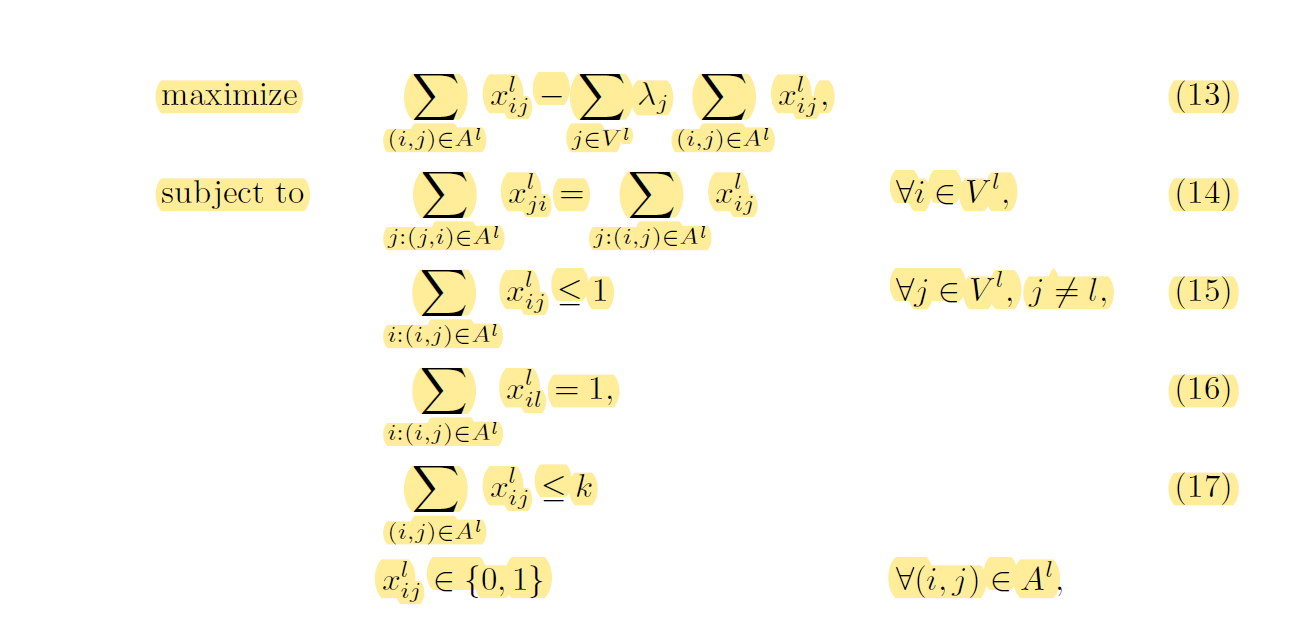